###  MicroGrad demo

In [192]:
import random
import numpy as np
import matplotlib.pyplot as plt


from micrograd.engine import Value
from micrograd.nn import Neuron, Layer, MLP

%matplotlib inline

In [193]:
np.random.seed(1337)
random.seed(1337)

In [194]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})

    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n._name, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

# Get MNIST dataset

In [195]:
from torchvision import datasets as dts

MNIST_DATASET = dts.MNIST(root = 'data', train = True, download=True)

X_train = MNIST_DATASET.data / 255.0 # * 2 - 1
X_train = X_train.reshape(X_train.shape[0], 784)

Y_train = MNIST_DATASET.targets

In [196]:
from collections import defaultdict
import torch

ALL_POSITIVE_CLASSES = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

NEG = -1.0
VOID = 0.0
POS = 1.0

def vals2tensor(values):
    if isinstance(values, torch.Tensor):
        return values
    if len(values):
        if isinstance(values[0], list):
            if len(values[0]):
                return torch.tensor([[v.data for v in vs] for vs in values])
        elif isinstance(values[0], Value):
            return torch.tensor([v.data for v in values])
    assert False


def oh_encode(classes: torch.tensor):
    if isinstance(classes, list):
        classes = torch.tensor(classes)

    assert classes.dim() == 1
    DIM = classes.shape[0]

    void = torch.tensor([VOID] * len(classes))

    oh_enc = defaultdict(lambda: void)
    oh_dec = defaultdict(lambda: None)

    for i, cls in enumerate(classes):
        cls_vec = torch.tensor([NEG] * classes.shape[0])
        cls_vec[i] = POS
        oh_enc[cls.item()] = cls_vec
        oh_dec[tuple(cls_vec.numpy())] = cls.item()

    def oh_decoder(encoded):
        encoded = vals2tensor(encoded)
        # pick the closest vector (is round() OK for that?)
        if len(encoded.shape) > 1:
            return [oh_dec[tuple(row.numpy())] for row in encoded]
        elif len(encoded.shape) == 1:
            assert encoded.shape[-1] == DIM, f'unfit OH encoding {encoded.shape[-1]} != {DIM} (targets dimention)'
            return oh_dec[tuple(encoded.numpy())]
        assert False

    def oh_encoder(Y):
        if isinstance(Y, list):
            Y = torch.tensor(Y)
        return torch.vstack([oh_enc[cls.item()] for cls in Y])

    return oh_encoder, oh_decoder

enc, dec = oh_encode(ALL_POSITIVE_CLASSES)
enc(ALL_POSITIVE_CLASSES)

tensor([[ 1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
        [-1.,  1., -1., -1., -1., -1., -1., -1., -1., -1.],
        [-1., -1.,  1., -1., -1., -1., -1., -1., -1., -1.],
        [-1., -1., -1.,  1., -1., -1., -1., -1., -1., -1.],
        [-1., -1., -1., -1.,  1., -1., -1., -1., -1., -1.],
        [-1., -1., -1., -1., -1.,  1., -1., -1., -1., -1.],
        [-1., -1., -1., -1., -1., -1.,  1., -1., -1., -1.],
        [-1., -1., -1., -1., -1., -1., -1.,  1., -1., -1.],
        [-1., -1., -1., -1., -1., -1., -1., -1.,  1., -1.],
        [-1., -1., -1., -1., -1., -1., -1., -1., -1.,  1.]])

In [197]:
import torch


def append_noise(X, noise_size, min=-1.0, max=1.0):
    noise_shape = torch.Size([noise_size]) + X.shape[1:]
    noise_tensor = torch.empty(noise_shape).uniform_(min, max)
    return torch.concat([X, noise_tensor])


def append_void(X, void_size, void=-1.0):
    void_shape = torch.Size([void_size]) + X.shape[1:]
    void_tensor = torch.empty(void_shape).fill_(void)
    return torch.concat([X, void_tensor])


def get_batch(X, Y, batch_size, noise_ratio=0.0, void_ratio=0.0, void_class=-1):
    ri = np.random.permutation(X.shape[0])[:batch_size]
    X, Y = X[ri], Y[ri]

    if noise_ratio > 0.0:
        noise_size = round(batch_size * noise_ratio)
        X = append_noise(X, noise_size)
        Y = torch.concat([Y, torch.tensor([void_class] * noise_size)])

    if void_ratio > 0.0:
        void_size = round(batch_size * void_ratio)
        X = append_void(X, void_size, void=np.random.uniform(0, 1))
        Y = torch.concat([Y, torch.tensor([void_class] * void_size)])

    return X, Y


def arr2vals(array, name=''):
    return [[Value(el, _name=name) for el in row] for row in array]


def batch2vals(batch):
    return tuple(map(arr2vals, batch))


In [198]:
def calc_accuracy(scores, targets, oh_decoder):
    matches = 0
    for score, target in zip(scores, targets):
        matches += oh_decoder(score) == oh_decoder(target)
    return matches / len(scores)


def one_loss(score, ground_truth):
    return sum(((s - gt) / 2) ** 2 for s, gt in zip(score, ground_truth) if gt.data != VOID)


def calc_loss(scores, targets):
    assert len(scores) == len(targets)
    return sum(one_loss(xs, ts) for xs, ts in zip(scores, targets))


def feed_forward(model, X):
    return list(map(model, X))


def evaluate(model, X, Y_oh, oh_decoder):
    input = arr2vals(X, 'input')
    scores = feed_forward(model, input)
    targets = arr2vals(Y_oh, 'expected')
    return calc_loss(scores, targets), calc_accuracy(scores, targets, oh_decoder), scores, targets

# save/load

In [199]:
POSITIVE_NEURONS = 'mnist_parameters_10x785_positives.npy'


def save_neurons(file, neurons):
    weights = np.array([[p.data for p in n.parameters()] for n in neurons])
    np.save(file, weights)


def load_neurons(file):
    weights = np.load(file)
    neurons = [Neuron(nin=weights.shape[1] - 1, act='xspace') for _ in range(weights.shape[0])]
    for Wi in range(len(neurons)):
        for p, w in zip(neurons[Wi].parameters(), weights[Wi]):
            p.data = w
            p._lr = 0.0
    return neurons

In [200]:
import matplotlib.pyplot as plt


def select(X, Y, selector):
    idx = np.where(np.isin(Y, selector))[0]
    return X[idx], Y[idx]


def select_batch(X, Y, selector, batch_size, noise_ratio=0.0, void_ratio=0.0, void_class=torch.nan):
    idx = np.where(np.isin(Y, selector))[0]
    return get_batch(X[idx], Y[idx], batch_size, noise_ratio, void_ratio, void_class)


def draw_neuron(model, neuron, layer=0):
    w = np.array([p.data for p in model.layers[layer].neurons[neuron].parameters()][:-1])
    w = w.reshape([-1, w.shape[0]])
    draw_some(w)


def one_neuron_histo(neuron, bins=100):
    array = np.array([p.data for p in neuron.parameters()])
    plt.hist(array, bins=bins, edgecolor='black')

    plt.title('Гистограмма нейрона')
    plt.xlabel('Вес')
    plt.ylabel('Частота')

    plt.show()


def draw_all_neurons(neurons):
    fig, axes = plt.subplots(1, len(neurons), sharey=True)
    if len(neurons) == 1:
        axes = [axes]

    for neuron, axe in zip(neurons, axes):
        array = np.array([p.data for p in neuron.parameters()][:-1])
        array = array.reshape([-1, array.shape[0]])
        axe.imshow(array.reshape([28, 28]))
    fig.suptitle("Нейроны")


def all_neurons_histo(neurons, bins=100):
    fig, axes = plt.subplots(1, len(neurons), sharey=True)
    if len(neurons) == 1:
        axes = [axes]

    for neuron, axe in zip(neurons, axes):
        array = np.array([p.data for p in neuron.parameters()])
        axe.hist(array, bins=bins, edgecolor='black')

    fig.suptitle('Гистограмма нейронов')
    fig.supxlabel('Вес')
    fig.supylabel('Частота')

    plt.show()

In [201]:
import math


def fit(model, X, Y_oh, oh_decoder, iterations, q=0.75, esat=1e-9):
    total_loss, acc, scores, targets = evaluate(model, X, Y_oh, oh_decoder)
    print(f"start: loss {total_loss.data}, accuracy {acc*100}%")

    for k in range(iterations):
        if total_loss.data == 0:
            print(f"step {k}: loss {total_loss.data}, accuracy {acc*100}%")
            return total_loss.data, acc, scores, targets

        model.learn_from(total_loss, q)
        model.norm()

        total_loss, acc, scores, targets = evaluate(model, X, Y_oh, oh_decoder)
        print(f"step {k}: loss {total_loss.data}, accuracy {acc*100}%")

        if total_loss.data <= esat:
            print(f"Early STOP!")
            break

    return total_loss, acc, scores, targets



def get_model_for(classes, batch, iterations, model=None, q=0.75, esat=1e-9, with_frozen_neurons=False):
    X, Y = batch
    DIM = len(classes)
    LAYER_0_SIZE = math.comb(DIM, 2) # + (DIM if not with_frozen_neurons else 0)

    oh_encoder, oh_decoder = oh_encode(classes)
    oh_decoder([Value(0)] * DIM)

    Y_oh = oh_encoder(Y)

    # initialize a model
    if model is None:
        model = MLP(
            784,
            [
                # (LAYER_0_SIZE, 'xspace'),
                (DIM, 'xspace')
            ],
            lr=1.0,
            init=lambda: -1.0
        )

    if with_frozen_neurons:
        frozen_positives = [n for c, n in enumerate(load_neurons(POSITIVE_NEURONS)) if c in classes]
        model.layers[0].neurons = model.layers[0].neurons + frozen_positives

    total_loss, acc, scores, targets = fit(model, X, Y_oh, oh_decoder, iterations, esat=esat, q=q)

    return (model, total_loss, acc), (scores, targets)

start: loss 10.0, accuracy 50.0%
step 0: loss 10.0, accuracy 50.0%


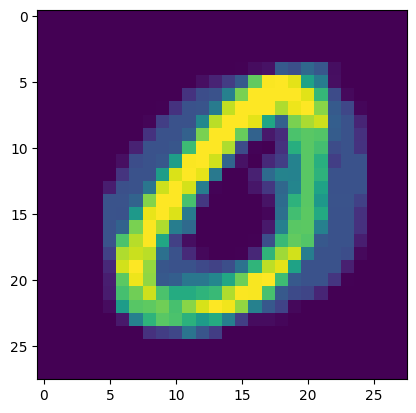

In [202]:
SELECTED_CLASSES = [0, 1]
NOISE_RATIO = 0.1
VOID_RATIO = 1.0
ITERATIONS = 1
BATCH_SIZE = 10
BATCH = select_batch(X_train, Y_train, SELECTED_CLASSES, BATCH_SIZE, void_ratio=VOID_RATIO)
X, Y = BATCH

(model, total_loss, accuracy), (scores, targets) = get_model_for(SELECTED_CLASSES, BATCH, ITERATIONS, q=0.5)
draw_neuron(model, 0)

# DEBUG

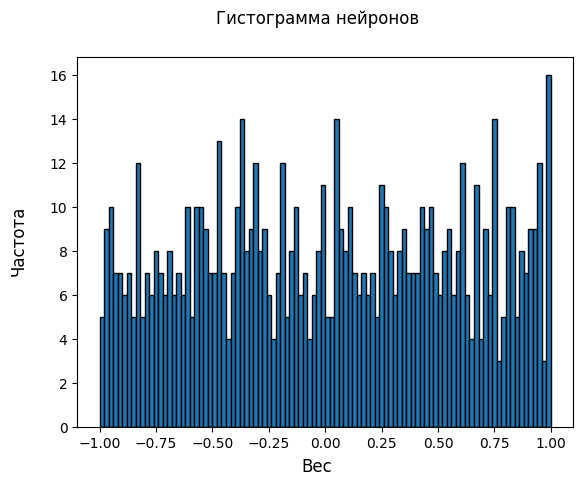

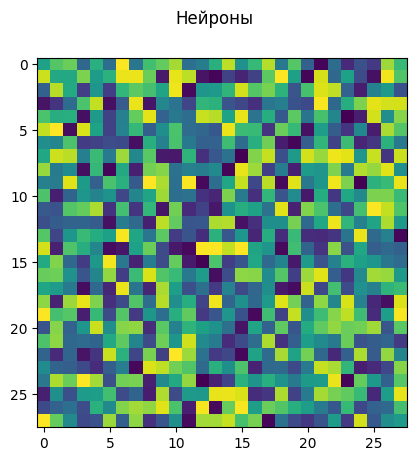

In [203]:
classes = [1, 2]

x, y = select_batch(X_train, Y_train, classes, 2, void_ratio=0)
oh_encoder, oh_decoder = oh_encode(classes)
y_oh = oh_encoder(y)

model = MLP(
    784,
    [
        (1, 'xspace'),
        (len(classes), 'xspace')
    ],
    lr=1.0,
    # init=lambda: -1.0
)

def loss():
    input = arr2vals(x, 'input')
    scores = feed_forward(model, input)
    targets = arr2vals(y_oh, 'target')

    total_loss = calc_loss(scores, targets)
    acc = calc_accuracy(scores, targets, oh_decoder)
    return total_loss, acc * 100

NEURONS = model.layers[0].neurons
all_neurons_histo(NEURONS)
draw_all_neurons(NEURONS)

start: loss 0.0, accuracy 100.0%


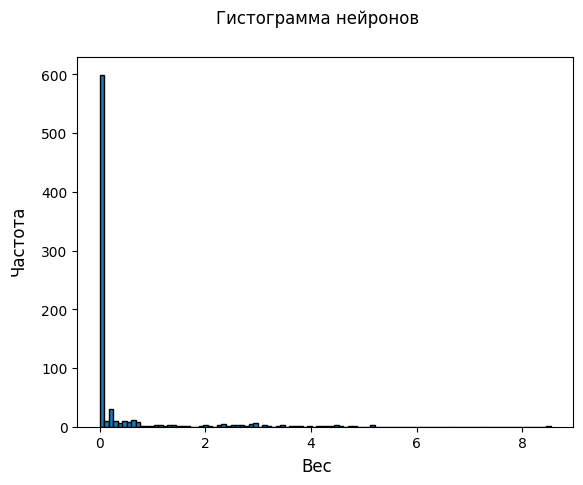

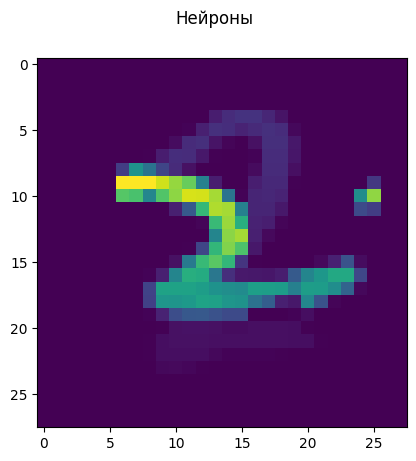

In [205]:
total_loss = None

def fit(total_loss):
    if total_loss is None:
        total_loss, _ = loss()

    total_loss.backward()
    model.learn_from(total_loss, q=1.0)
    model.norm()

    return loss()

total_loss, acc = fit(total_loss)
print(f"start: loss {total_loss.data}, accuracy {acc}%")

NEURONS = model.layers[0].neurons
all_neurons_histo(NEURONS)
draw_all_neurons(NEURONS)

In [206]:
import pandas as pd

numbers = [p.data for p in model.layers[0].neurons[0].parameters()]
numbers.sort()

pd.DataFrame(numbers).describe()

,0
count,785.000000
mean,0.372999
std,1.000638
min,-0.001893
25%,-0.000593
50%,0.000793
75%,0.052977
max,8.534852
